In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

<font size=6>**Classical Statistics: Maximum Likelihood Estimation**</font>


# 1. RR Lyrae stars in M4

RR Lyrae stars are variable pulsators that obey a precise period-luminosity relation. Here we have a sample of RR Lyrae stars in the globular cluster M4, observed with Spitzer by Neeley et al. (2015): http://cdsads.u-strasbg.fr/abs/2015ApJ...808...11N

Since the stars are at the same distance, then the apparent magnitude will also depend on the period::

$$ m = a\ {\rm log}\ P + b $$

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table

RR_lyrae_table2 = Table.read('./data/table2.dat', readme='./data/ReadMe', format='cds')
RR_lyrae = RR_lyrae_table2[RR_lyrae_table2['Mode'] == 'RRab']

# Now remove sources V20 and V21 due to blending
RR_lyrae = RR_lyrae[RR_lyrae['ID'] != 'V20']
RR_lyrae = RR_lyrae[RR_lyrae['ID'] != 'V21']

print("Columns:", RR_lyrae.colnames)
logP, m36, e_m36 = RR_lyrae["logP"], RR_lyrae['[3.6]'], RR_lyrae['e_[3.6]']
logP, m36, e_m36 = logP[~m36.mask], m36[~m36.mask], e_m36[~m36.mask]

Columns: ['ID', 'RAh', 'RAm', 'RAs', 'DE-', 'DEd', 'DEm', 'DEs', 'Per', 'logP', '[3.6]', 'e_[3.6]', 'f_[3.6]', '[4.5]', 'e_[4.5]', 'f_[4.5]', '3.6amp', 'e_3.6amp', '4.5amp', 'e_4.5amp', 'Mode', 'f_Mode']


## 1.1. The data

Let's plot the data from the 3.6μ band:

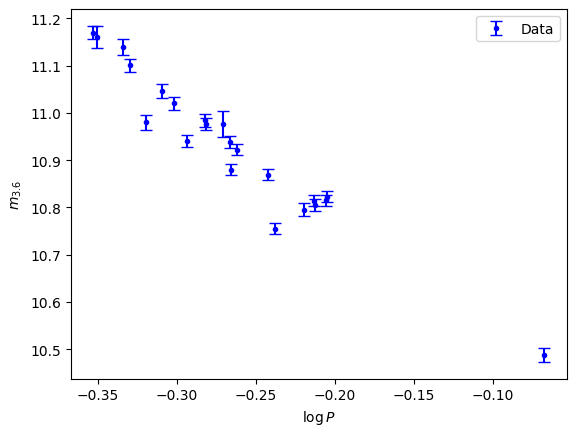

In [3]:
xx = np.linspace(np.min(logP), np.max(logP), 40)

plt.figure()
plt.errorbar(logP, m36, yerr=e_m36, fmt="b.", capsize=4, label="Data")
plt.legend(loc="upper right")
plt.xlabel(r"$\log P$")
plt.ylabel(r"$m_{3.6}$")
plt.show()

## 1.2. Quick Python code for fitting

1. `numpy.polyfit` method for fitting polynomials

> It actually performs an ordinary least squares fit, obviously without taking into account the uncertainties 

2. `scipy.optimize.minimize` can minimize any function

> ...so we can apply it to minimize the $\chi^2$ (using the uncertainties). Note that the optimization method is selected because it's not always successful

3. **A trick**

> $\chi^2$ fitting can be seen as a *weighted version* of ordinary least squares. The weight are applied on the unsquared residuals: $ w_i \left[y_i - \hat{y}(x_i)\right]$.
By comparing with the $\chi^2$ formula we can use $1/\sigma_i$ as weights in `numpy.polyfit` where $\sigma_i$ are the uncertainties of each data point.


<div class="alert alert-block alert-warning" style="margin-top: 20px">

**Tasks:** 
    
1. Make `np.polyfit` work
2. Select the initial guess for minimizing `chi_square`
3. Make `np.polyfit` work with the correct weights
</div>

Polyfit output:
[-2.369672   10.29960037]

Minimization output:
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 186.90598361947244
             x: [-2.338e+00  1.030e+01]
           nit: 34
          nfev: 66
 final_simplex: (array([[-2.338e+00,  1.030e+01],
                       [-2.338e+00,  1.030e+01],
                       [-2.338e+00,  1.030e+01]]), array([ 1.869e+02,  1.869e+02,  1.869e+02]))
Optimal Parameters:
[-2.33806527 10.30379998]

chi-square fitting using weighted polyfit:
[-2.33808939 10.30379338]


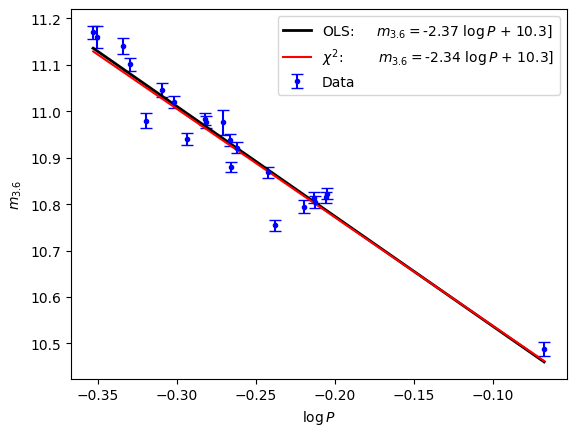

In [4]:
# ordinary least squares fit

ols_params = np.polyfit(logP, m36, deg=1)
print("Polyfit output:")
print(ols_params)
print()


# chi-square fitting using minimization

def chi_square(params):
    a, b = params
    m36_model = a * logP + b
    return np.sum((m36 - m36_model) ** 2.0 / e_m36**2.0)

from scipy.optimize import minimize
initial_estimate = ols_params             # use the OLS results as an initial estimate
min_result = minimize(chi_square, x0=initial_estimate, method="Nelder-Mead")
print("Minimization output:")
print(min_result)
print("Optimal Parameters:")
print(min_result.x)


# chi-square fitting using weighted ordinary least squares fit: w = 1/sigma here!

ch2_params = np.polyfit(logP, m36, deg=1, w=1.0/e_m36)
print()
print("chi-square fitting using weighted polyfit:")
print(ch2_params)


# plotting the results

xx = np.linspace(np.min(logP), np.max(logP), 40)
plt.figure()
plt.errorbar(logP, m36, yerr=e_m36, fmt="b.", capsize=4, label="Data")
plt.plot(xx, np.polyval(ols_params, xx), "k-", lw=2, label=f"OLS:\t $m_{{3.6}} = ${ols_params[0]:.3g} $\log P$ + {ols_params[1]:.3g}]")
plt.plot(xx, np.polyval(ch2_params, xx), "r-", label=f"$\chi^2$:\t $m_{{3.6}} = ${ch2_params[0]:.3g} $\log P$ + {ch2_params[1]:.3g}]")
plt.legend(loc="upper right")
plt.xlabel(r"$\log P$")
plt.ylabel(r"$m_{3.6}$")
plt.show()

## 1.3. Constructing a likelihood function

Our problem falls into the general case where we have a model connecting two quantities through a function with two parameters, $a$ and $b$: $y=f(x;a,b)=ax + b$.

In the general case, we use $\theta$ as a list of parameters: $\theta = \{\theta_1, \theta_2, \cdots, \theta_k\}$: 

$$ \Large y = f(x; \theta) $$

Therefore, if we get $N$ data, $(x_i, y_i)$ for $i \in [1, 2, \cdots, N]$ based on the model we would expect:

$$\Large y_i = f(x_i; \theta) $$

However, all observations are **subject to uncertainty**, and we need to model this as well. More often than not, uncertainties are fluctuations of a certain magnitude $\sigma$ around 0, following the Gaussian distribution:

$$\Large y_i = f(x_i; \theta) + \epsilon_i $$

where $\epsilon_i$ is normally distributed:

$$\Large \epsilon_i \sim \mathrm{Norm}(0, \sigma_i)$$

The $\sigma_i$ is the standard deviation of the datum error distribution, or an **estimate** of the typical difference between the observed $y_i$ and the intrinsic, true value $y_i$ which we **assume that is described by the model**.

Consequently, according to our model, the probability to observe the $i$-th point's $y$-value given it's $x$-value, or the **datum likelihood** is

$$\Large
P(y_i | x_i) = \text{Norm}(y_i; f(\theta; x_i), \sigma_i) 
   = \dfrac{1}{\sqrt{2\pi \sigma_i^2}} \exp \left[{-\dfrac{(y_i-f(x_i; \theta))^2}{2\sigma_i^2}} \right]
$$

Assuming that our measurements are independent (the probability of $y_2$ does not depend on $y_1$), the overall probability to get our data, or **likelihood** (always **according to our model**) is the product of all likelihoods:

$$\Large L = \prod_{i=1}^{N} P(y_i | x_i)$$

Let's do the math...

$$\Large
L = \prod_{i=1}^{N} \dfrac{1}{\sqrt{2\pi \sigma_i^2}} \exp \left[{-\dfrac{(y_i-f(x_i))^2}{2\sigma_i^2}} \right]
$$

$$\Large
L = \left(\dfrac{1}{\sqrt{2\pi \sigma_i^2}}\right)^N \exp \left[ -\sum_{i=1}^{N} {\dfrac{(y_i-f(x_i))^2}{2\sigma_i^2}} \right]
$$

The parameters that maximize the likelihood are found by taking

$$\Large \frac{\partial L}{\partial a} = 0 \qquad\text{and}\qquad \Large \frac{\partial L}{\partial b} = 0$$


## The log trick

The likelihoods are typicall very small quantities. To avoid numerical issues, we are allowd to work in log-space (they are positive):

$$\Large
l = \ln{L} = -\frac{N}{2} \ln\left(2\pi \sigma^2\right) - \sum_{i=1}^{N} {\dfrac{(y_i-f(x_i))^2}{2\sigma_i^2}}
$$

Not only it simplifies the equation, but it's convenient for maximization with respect to any parameter $\theta_j$:

$$ \Large                      \frac{\partial \ln L}{\partial \theta_j}        = 0 
   \quad\Leftrightarrow\quad   \frac{1}{L}\frac{\partial L}{\partial \theta_j} = 0 
   \quad\Leftrightarrow\quad   \frac{\partial L}{\partial \theta_j}            = 0 $$

Therefore, for our example we can maximizing the log-likelihood with respect to the two parameters:

$$\Large \frac{\partial l}{\partial a} = 0 \qquad\text{and}\qquad \Large \frac{\partial l}{\partial b} = 0.$$


## Connection with $\chi^2$

The $l$ can be written as

$$\Large
l = \text{constant} - \frac{1}{2} \sum_{i=1}^{N} {\dfrac{(y_i-f(x_i))^2}{\sigma_i^2}} = \text{constant} - \frac{\chi^2}{2}
$$


Consequently, maximizing the likelihood is equivalent to minimizing the $\chi^2$!



## If the uncertainties are equal...

If $\sigma_i \equiv \sigma$, then... 

$$\Large
l = \text{constant} - \frac{1}{2} \sum_{i=1}^{N} {\dfrac{(y_i-f(x_i))^2}{\sigma_i^2}} =
\text{constant} - \frac{1}{2\sigma^2} \sum_{i=1}^{N} {(y_i-f(x_i))^2}
$$


So maximizing the likelihood corresponds to minimizing the quantity

$$\Large \sum_{i=1}^{N} (y_i-f(x_i))^2 $$

...or the **sum of the squares**!

In fact, using $f(x) = a x + b$ you will arrive at the known OLS formulae for linear fitting without using linear algebra at all!

## 1.4. Let's plot the likelihood close to the solution we found before

<div class="alert alert-block alert-warning" style="margin-top: 20px">

**Task:** Complete the `log_likelihood` function.
</div>

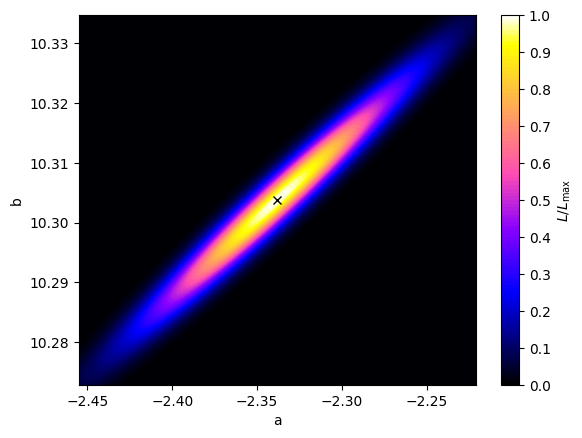

In [5]:
# construct a 2D grid with 101 points in each direction
a_grid = np.sort(np.linspace(0.95 * ch2_params[0], 1.05 * ch2_params[0], 101))
b_grid = np.sort(np.linspace(0.997 * ch2_params[1], 1.003 * ch2_params[1], 101))
[A, B] = np.meshgrid(a_grid, b_grid)


# construct the likelihood function (and vectorize it to be applied directly on arrays)
@np.vectorize
def log_likelihood(a, b):
    return -0.5*chi_square([a, b])


lnL = log_likelihood(A, B)    # compute the likelihood in each grid point
lnL = lnL - np.max(lnL)       # normalizing it for the maximum to be 0.0
L = np.exp(lnL)               # un-log it to better visualization

# plot the results
plt.figure()
plt.contourf(A, B, L, 100, cmap='gnuplot2')
plt.plot(*ch2_params, "xk")
plt.xlabel("a")
plt.ylabel("b")
cbar = plt.colorbar(label=r"$L / L_{\max}$")
cbar.set_ticks(np.linspace(0, 1, 11))
plt.show()

# 2. Exercise: fitting for slope only

Let's assume that in the above relation, the intercept $b$ is known (it mainly depends on the distance of the objects, and a calibration of the relation):

$$ m = a\ {\rm log}\ P + 10.3 $$

<font size=3><u>**In-class discussion: Can we fit the slope using standard methods for fitting a line (OLS)?**</u><font>

<details>
<summary><b>[Spoiler]</b></summary>
<br>
We do not have an intercept any more. Even if we fit $m-10.3$, we might end up with a small "remainder". 
Even if we take the logs again, we would have $\log(m-10.3) = \log a + \log\log P$ which requires fitting for the intercept only.
Perhaps, $a = (m - 10.3) / \log P$ is telling us that from each point we have an estimate of the slope and we could average them.
But none of these approaches takes into account the uncertainties.
<br>

In [6]:
ols_params_1param = np.polyfit(logP, m36-10.3, deg=1)
print("Ordinary Least Squares result:     a={:.3f}, b={:.3g}".format(*ols_params_1param))

slope_estimates = (m36-10.3) / logP
mean_slope = np.mean(slope_estimates)
print(f"Average of slope estimates:        a={mean_slope:.3f}")

Ordinary Least Squares result:     a=-2.370, b=-0.0004
Average of slope estimates:        a=-2.380


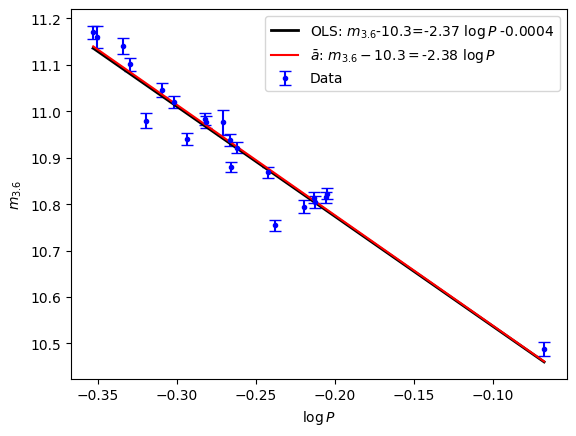

In [7]:
xx = np.linspace(np.min(logP), np.max(logP), 40)
plt.figure()
plt.errorbar(logP, m36, yerr=e_m36, fmt="b.", capsize=4, label="Data")
plt.plot(xx, 10.3 + np.polyval(ols_params_1param, xx), "k-", lw=2, label=f"OLS: $m_{{3.6}}$-10.3={ols_params_1param[0]:.3g} $\log P$ {ols_params_1param[1]:+.3g}")
plt.plot(xx, 10.3 + mean_slope * xx, "r-", label=f"$\\bar{{a}}$: $m_{{3.6}} - 10.3 = ${mean_slope:.3g} $\log P$")
plt.legend(loc="upper right")
plt.xlabel(r"$\log P$")
plt.ylabel(r"$m_{3.6}$")
plt.show()

<font size=3><u>**In-class discussion: Can we fit the slope using $\chi^2$-fitting?**</u><font>

<details>
<summary><b>[Spoiler]</b></summary>
<br>
    Sure! This includes the uncertainties, and we are using directly the likelihood we want.
<br>

In [8]:
chi2_min_result = minimize(lambda a: np.sum((m36-10.3-a*logP)**2.0 / e_m36**2.0), x0=mean_slope)
print(f"Chi-square minimization estimate:  a={chi2_min_result.x[0]:.3f}")

Chi-square minimization estimate:  a=-2.352


<font size=3><u>**In-class discussion: What is the uncertainty on the slope?**</u><font>

<details>
<summary><b>[Spoiler]</b></summary>
<br>
Most methods (OLS, $\chi^2$) have ways to get the uncertainties of the parameters. These are based on Gaussian approximations of the likelihood itself! 
Here we have the likelihood, why not use it?
<br>

## 2.1. Plotting the (log-)likelihood

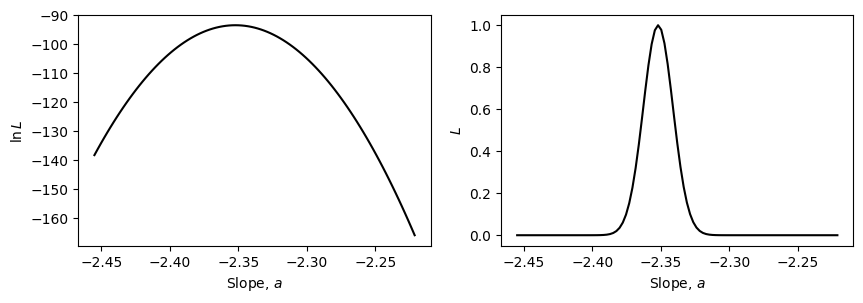

In [9]:
def log_likelihood_1param(slope):
    return -0.5*np.sum((m36-10.3 - slope*logP)**2.0 / e_m36**2.0)

# the slope values to try
a_values = a_grid.copy()

# the corresponding log-likelihood values
lnL_values = np.array([log_likelihood_1param(a_value) for a_value in a_values])

# the likelihood values, normalized to 1
L_values = np.exp(lnL_values - np.max(lnL_values))


fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(10, 3))
ax1.plot(a_values, lnL_values, "k-")
ax1.set_ylabel(r"$\ln L$")
ax2.plot(a_values, L_values, "k-")
ax2.set_ylabel(r"$L$")
for ax in [ax1, ax2]:
    ax.set_xlabel("Slope, $a$")
plt.show()

## 2.2. Estimating the uncertainty through the CDF

What does the *uncertainty on the slope* mean? The likelihood function gives all the information. Sigma values, upper and lower limits, are simply summarizing the likelihood using 1-2 values.

We can **define** as 68% confidence interval on the slope, the region around the median, where the area under the (properly normalized) likelihood is 68%:

$$\Large \int\limits_{lo}^{up} L(a) da = 0.68 $$

where $lo$ and $hi$ are the lower and upper bounds of the CI. Since we defined the CI as something around the median, this implies that the $lo$ and $up$ values correspond to the 16 and 84 percentiles. Therefore:

$$\Large \int\limits_{-\infty}^{lo} L(a) da = 0.16 $$

$$\Large \int\limits_{-\infty}^{up} L(a) da = 0.84 $$

This is why the **cumulative density function** (CDF) is very useful! We can obtain the CDF by integrating the likelihood:

$$\Large F(a') = \int\limits_{-\infty}^{a'} L(a) da $$

Since we have calculated $f(x)$ on a regular and fine grid of $x$, i.e., $\Delta x$ is constant and a small value. Consequently, the integral calculated in the same grid, is simply the **cumulative sum** of the likelihood values in the grid. Of course, we need to **normalize** it so that the CDF at infinity is 1. Since we started with a wide range of $x$ (including most of the likelihood), we can assume that the CDF goes from 0 to 1.

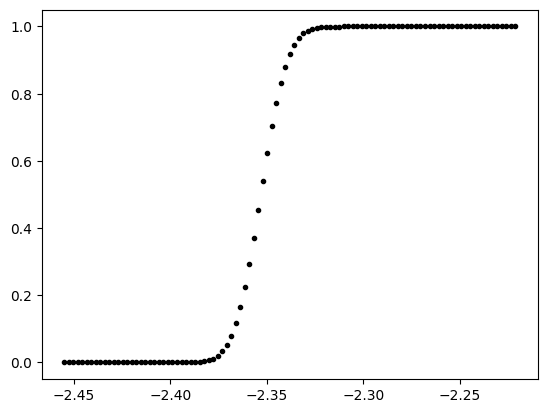

In [10]:
cdf = np.cumsum(L_values)
cdf /= cdf[-1]

plt.figure()
plt.plot(a_values, cdf, "k.")
plt.show()

## 2.3. Finding the confidence interval

The CDF calculated in the grid is a series of point. To find the value at which the CDF is say, 0.16, we can use interpolation! But not the typical one where we interpolate $y$ values from $x$ values, but the opposite!

<div class="alert alert-block alert-warning" style="margin-top: 20px">

**Task:** Use interpolation to find the confidence interval and the median of the slope.
</div>

Slope = -2.353 +0.011 -0.011


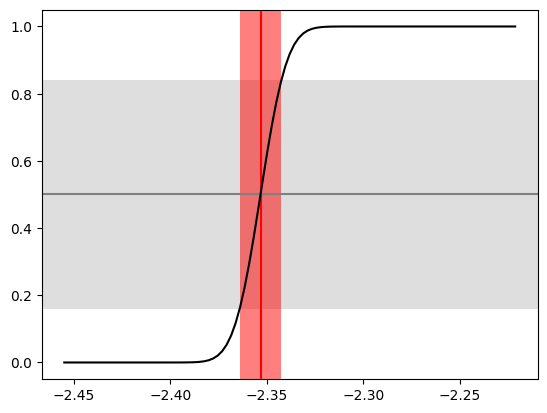

In [11]:
lo68, median, hi68 = np.interp([0.16, 0.50, 0.84], cdf, a_values)
print(f"Slope = {median:.3f} +{hi68-median:.3f} -{median-lo68:.3f}")

plt.figure()
plt.axhspan(0.16, 0.84, facecolor="0.75", alpha=0.5, edgecolor="none")
plt.axvspan(lo68, hi68, facecolor="r", alpha=0.5, edgecolor="none")
plt.axvline(median, color="r")
plt.axhline(0.50, color="0.5", ls="-")
plt.plot(a_values, cdf, "k-")
plt.show()

## Additional considerations

1. The grid is not necessary. We can directly calculate any percentile by defining the CDF as a function that integrates (e.g., with `scipy.integrate`), and then using root finders or minimizers (e.g., with `scipy.optimize`), find the value for which it gives 0.16 or 0.84!

2. We can directly use the likelihood to calculate other statistics using formulas applied on distribution functions:

Mean: $ \mu = \int\limits_{-\infty}^{+\infty} x L(x)\, dx$

Variance: $\text{Var} = \int\limits_{-\infty}^{+\infty} \left(x - \mu\right)^2 L(x) dx$

Standard deviation: $\sigma = \sqrt{\text{Var}}$

...and so on! It involves integrations that are typically easy to calculate with standard methods (if the likelihood is smooth).

# 3. Hypothesis testing in the framework of correlations

## 3.1. Dependence/independence of random variables
Sometimes we want to test whether two quantities are (un)correlated, or *(in)dependent*. This is useful for 
* confirming a model predicting that such a correlation exists
* predicting a quantity (e.g., 'y' from 'x')
* verify a monotonic relation between two quantities

## 3.2. Linear correlation tests

We can perform an ordinary least-squares fit to get the best-fitting values of $a$ and $b$. The function `linregress` provided by the `scipy` package can also be used, as it also returns a $p$-value based on the result!  

The documentation reports:
> The p-value for a hypothesis test whose null hypothesis is that the slope is zero, using Wald Test with t-distribution of the test statistic.


FIT RESULTS:
    slope          : -2.37 +/- 0.14
    intercept      : 10.30 +/- 0.04
    corr. coeff. R : -0.967081
    R squared      : 0.935245
    p-value        : 2.35445e-13


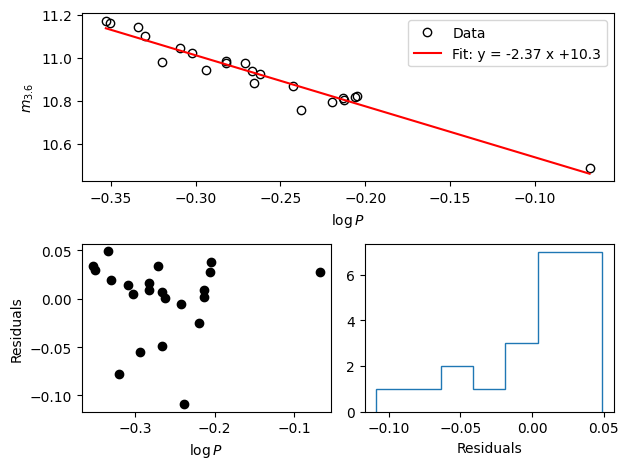

In [12]:
import scipy.stats as st
res = st.linregress(x=logP, y=m36)

slope, intercept, rvalue, pvalue, slope_stderr = res
intercept_stderr = res.intercept_stderr                # for compatibility this value is extracted like this

print("FIT RESULTS:")
print("    slope          : {:.2f} +/- {:.2f}".format(slope, slope_stderr))
print("    intercept      : {:.2f} +/- {:.2f}".format(intercept, intercept_stderr))
print("    corr. coeff. R : {:.6f}".format(rvalue))
print("    R squared      : {:.6f}".format(rvalue**2.0))
print("    p-value        : {:.6g}".format(pvalue))

x_plot = np.array([min(logP), max(logP)])
y_plot = slope * x_plot + intercept

plt.figure()
plt.subplot(211)
plt.plot(logP, m36, "ko", mfc="none", label="Data")
plt.plot(x_plot, y_plot, "r-", label="Fit: y = {:.3g} x {:+.3g}".format(slope, intercept))
plt.xlabel(r"$\log P$")
plt.ylabel(r"$m_{3.6}$")
plt.legend(loc="upper right")

residuals = m36 - (slope * logP + intercept)
# plt.figure(constrained_layout=True)
plt.subplot(223)
plt.plot(logP, residuals, "ko")
plt.xlabel(r"$\log P$")
plt.ylabel("Residuals")
plt.subplot(224)
plt.hist(residuals, bins="fd", histtype="step")
plt.xlabel("Residuals")
plt.tight_layout()
plt.show()

Pearson correlation coefficient:

$$ \large \rho = \dfrac{\mathrm{cov}\left(X, Y\right)}{\sigma_X \sigma_Y} $$

For a sample:

$$ \large
    r = \dfrac{
              \sum\limits_{i=1}^{n}\left(x_i - \bar{x}\right)\left(y_i - \bar{y}\right)
              }
              {
              \sqrt{
              \sum\limits_{i=1}^{n}\left(x_i - \bar{x}\right)^2
              \sum\limits_{i=1}^{n}\left(y_i - \bar{y}\right)^2
              }
              }
$$

- 0: no correlation. 
- 1: perfect correlation
- -1: perfect anti-correlation.

The square of $r$, usually refered as **R-squared** in the literature, is the *percentage of explained variance through the linear correlation*.

Therefore, a $p$-value smaller than our significance level, means that **we reject the hypothesis that the slope is 0**, which can be rephrased as **we cannot reject the hypothesis that there is a linear correlation**.

**Warning**: this doesn't mean that we accept that the correlation is linear. We get the above result *assuming linear correlation*!


### If we do not need to fit, we can use the `pearsonr` function to perform the hypothesis test

**Warning**: this does not alleviate the caveat that the correlation might not be linear!

<div class="alert alert-block alert-warning" style="margin-top: 20px">

**Task:** Complete the `pearsonr` statement.
</div>

In [13]:
st.pearsonr(logP, m36)

PearsonRResult(statistic=-0.967080833366053, pvalue=2.354447449396205e-13)

## 3.3. Monotonicity test

Sometimes a linear correlation is not easy to see! For example, if we had no intuition about the connection between the $\log P$ and the magnitude in RR Lyrae, we might have tried to plot period and luminosity.

In that case, the model becomes $L = A P^{\gamma}$. It's not linear anymore... 

Also, if we have fewer data points, the linear correlation becomes weak.

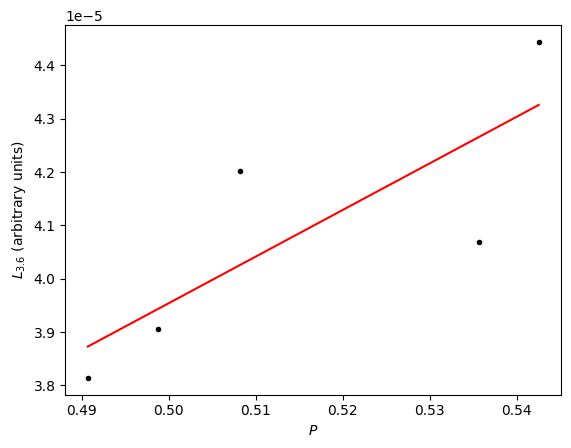

In [14]:
P = 10.0**logP
L = 2.512**-m36

subset = [0, 2, 3, 5, 9]
x_new, y_new = P[subset], L[subset]

slope, intercept, _, _, _ = st.linregress(x_new, y_new)

xx = np.linspace(min(x_new), max(x_new), 100)
plt.figure()
plt.plot(x_new, y_new, "k.")
plt.plot(xx, slope * xx + intercept, "r-")
plt.xlabel(r"$P$")
plt.ylabel(r"$L_{3.6}$ (arbitrary units)")
plt.show()

To test for such dependences, we can perform a **monotonicity test**. There are two widely used monotonicity checks through the *Spearman rank correlation coefficient* $r_s$ and the *Kendall rank correlation coefficient* $\tau$ often referred as *Kendall's $\tau$*. Their power relies on the fact that they are *non-parametric* and therefore they do not rely on an assumed model describing the data.

For $r_s$ and $\tau$:
- 0: $x$ and $y$ are independent
- 1: strictly increasing
- -1: strictly decreasing

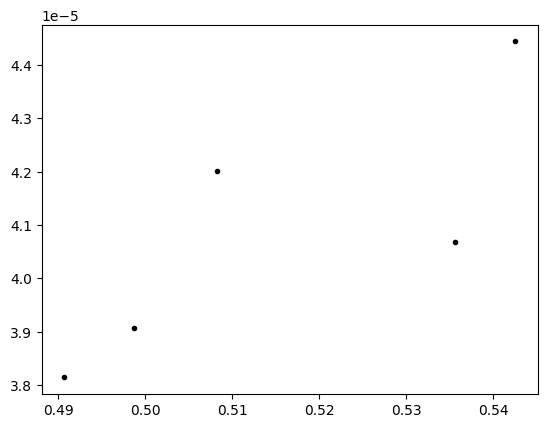

PEARSON  : r = 0.801  |  p-value = 0.103
SPEARMAN : r = 0.900  |  p-value = 0.0374
KENDALL  : t = 0.800  |  p-value = 0.0833


In [15]:
plt.figure()
plt.plot(x_new, y_new, "k.")
plt.show()
# report correlation tests' p-values
r, pvalue = st.pearsonr(x_new, y_new)
print("PEARSON  : r = {:.3f}  |  p-value = {:.3g}".format(r, pvalue))
r, pvalue = st.spearmanr(x_new, y_new)
print("SPEARMAN : r = {:.3f}  |  p-value = {:.3g}".format(r, pvalue))
r, pvalue = st.kendalltau(x_new, y_new)
print("KENDALL  : t = {:.3f}  |  p-value = {:.3g}".format(r, pvalue))

<font size=3><u>**In-class discussion: How do you interprete the high Pearson's $r$-value?**</u><font>

_Discuss with your teammate, then report._

<details>
<summary><b>[Spoiler]</b></summary>
<br>
Despite the fact that the correlation is obvisouly non-linear, even the wrong model has to have a non-zero slope! Always remember your $H_0$ hypothesis! A small $p$-value or high $R^2$ does not validate the functional form of the model!
<br>

# 4. Fitting a spectral line using MLE

Astrophysics loves spectra since extracting features from them is extremely informative regarding the physical processes of astronomical objects.

In this example we'll try to fit the LiI spectral line using a stellar spectrum.

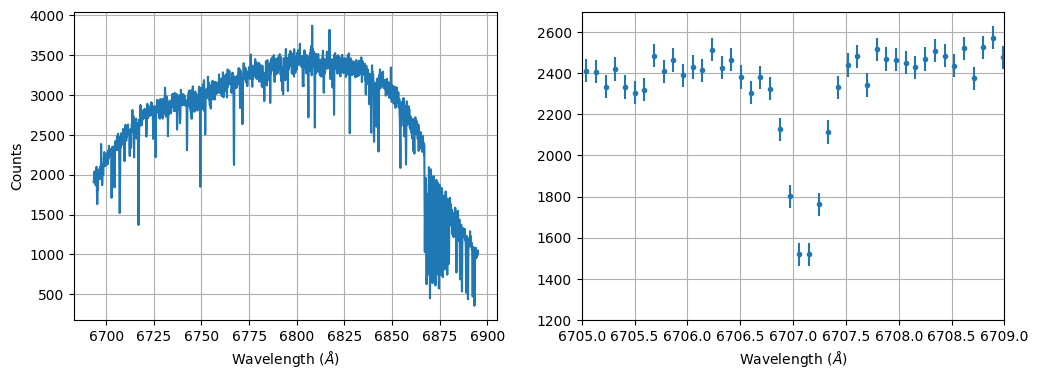

In [16]:
spectrum = np.load("data/lithium_line_example.npy")

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(spectrum['wavelength'], spectrum['flux'])
ax[1].errorbar(spectrum['wavelength'], spectrum['flux'], yerr=spectrum['flux_error'], fmt='. ')

ax[1].set_xlim(6705, 6709)
ax[1].set_ylim(1200, 2700)

for a in ax:
    a.grid()

ax[0].set_xlabel(r'Wavelength ($\AA$)')
ax[1].set_xlabel(r'Wavelength ($\AA$)')
ax[0].set_ylabel('Counts')

plt.show()

### Let's focus on the lithium line

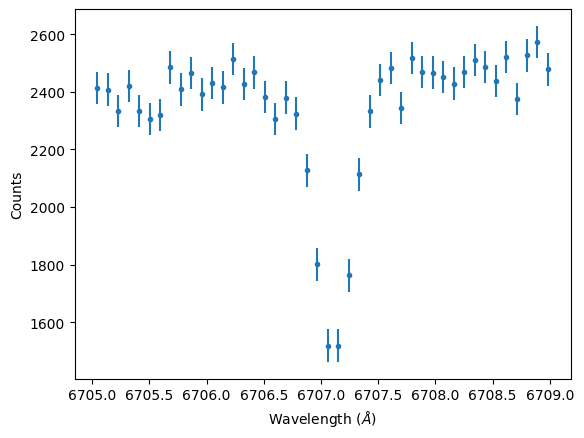

In [17]:
lithium_line = spectrum[spectrum['wavelength'] > 6705]
lithium_line = lithium_line[lithium_line['wavelength'] < 6709]


plt.errorbar(lithium_line['wavelength'], lithium_line['flux'], 
             yerr=lithium_line['flux_error'], 
             fmt=' .')

plt.xlabel(r'Wavelength ($\AA$)')
plt.ylabel('Counts')

plt.show()

### Let's start by describing our model: a linear continuum plus a Gaussian absorption feature

<div class="alert alert-block alert-warning" style="margin-top: 20px">

**Tasks:**
1. Create the model: continuum + Gaussian line
2. Decide the return value of `ln_likelihood` for values outside the permitted ranges of the parameters
3. Complete the `ln_likelihood` function
</div>

In [18]:
def model_flux(p, wavelength):
    """Return the flux for our model.
    
    Arguments
    ---------
    p : tuple
        The model parameters
    wavelength : float
        The input wavelength(s) at which we wish to calculate our model
        
    Returns
    -------
    flux : float
        The model flux(es) calculated by our model
    """
    
    m, b, c, sigma, loc = p
    
    linear_part = m*(wavelength-6707) + b
    gaussian_part = -c * st.norm.pdf(wavelength, loc=loc, scale=sigma)
    
    return linear_part + gaussian_part

def ln_likelihood(p, data):
    """Return the likelihood of our model.
    
    Arguments
    ---------
    p : tuple
        The model parameters
    data : ndarray
        The observed data from which we wish to calculate the likelihood of our model
        
    Returns
    -------
    ln_likelihood : float
        The log likelihood of our model
    """
    
    m, b, c, sigma, loc = p
    if sigma <= 0: return -np.inf
    if loc < 6706 or loc > 6708: return -np.inf
    
    # First, calculate the model fluxes at the observed wavelengths
    model_fluxes = model_flux(p, data['wavelength'])
    
    # Now capture our observed fluxes
    observed_fluxes = data['flux']
    observed_flux_errors = data['flux_error']
    
    # Compare the two
    ln_likelihood = -np.log(observed_flux_errors * np.sqrt(2*np.pi)) - (model_fluxes - observed_fluxes)**2 / (2 * observed_flux_errors**2)
        
    return sum(ln_likelihood)

def neg_ln_likelihood(p, data):
    """Wrapper for ln_likelihood to return the negative of the log likelihood.
    
    Arguments
    ---------
    p : tuple
        The model parameters
    data : ndarray
        The observed data from which we wish to calculate the likelihood of our model
        
    Returns
    -------
    neg_ln_likelihood : float
        The negative of the log likelihood of our model
    """

    return -ln_likelihood(p, data)


### Let's start with a trial solution and use scipy minimize to find a solution

/tmp/ipykernel_336677/926791788.py:14: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(lithium_line['wavelength'], lithium_line['flux'],


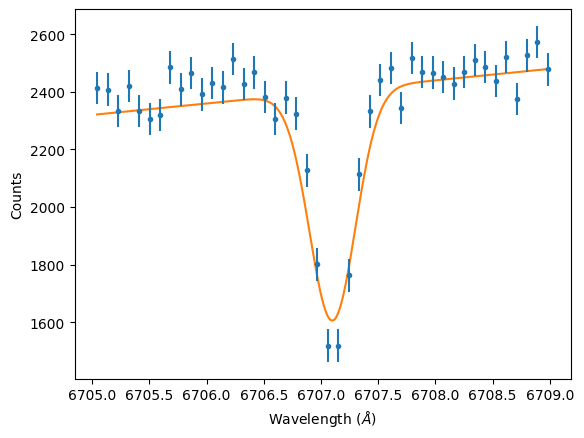

In [19]:
m = 40
b = 2400
c = 400
sigma = 0.2
loc = 6707.1

p0 = (m, b, c, sigma, loc)

model_wavelengths = np.linspace(np.min(lithium_line['wavelength']), np.max(lithium_line['wavelength']), 1000)
model_fluxes = model_flux(p0, model_wavelengths)

plt.plot(model_wavelengths, model_fluxes, color='C1')

plt.errorbar(lithium_line['wavelength'], lithium_line['flux'], 
             yerr=lithium_line['flux_error'], 
             fmt='o', marker='.')

plt.xlabel(r'Wavelength ($\AA$)')
plt.ylabel('Counts')

plt.show()

/tmp/ipykernel_336677/2816611523.py:9: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(lithium_line['wavelength'], lithium_line['flux'],


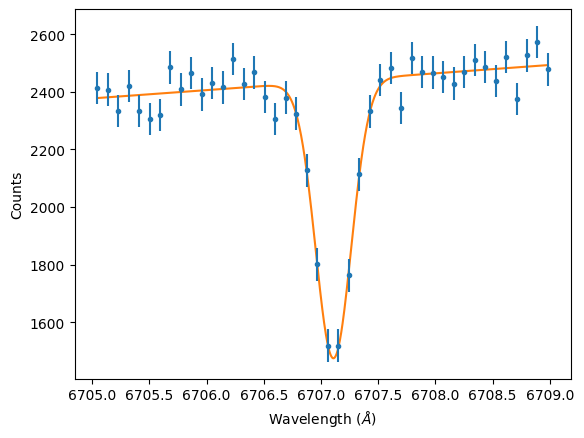

In [20]:
res = minimize(neg_ln_likelihood, p0, method='Nelder-Mead', args=lithium_line)

best_p = res.x
model_wavelengths = np.linspace(np.min(lithium_line['wavelength']), np.max(lithium_line['wavelength']), 1000)
model_fluxes = model_flux(best_p, model_wavelengths)

plt.plot(model_wavelengths, model_fluxes, color='C1')

plt.errorbar(lithium_line['wavelength'], lithium_line['flux'], 
             yerr=lithium_line['flux_error'], 
             fmt='o', marker='.')

plt.xlabel(r'Wavelength ($\AA$)')
plt.ylabel('Counts')

plt.show()

### How does the likelihood vary with model parameters?

Let's see how the likelihood will vary with the the model parameters

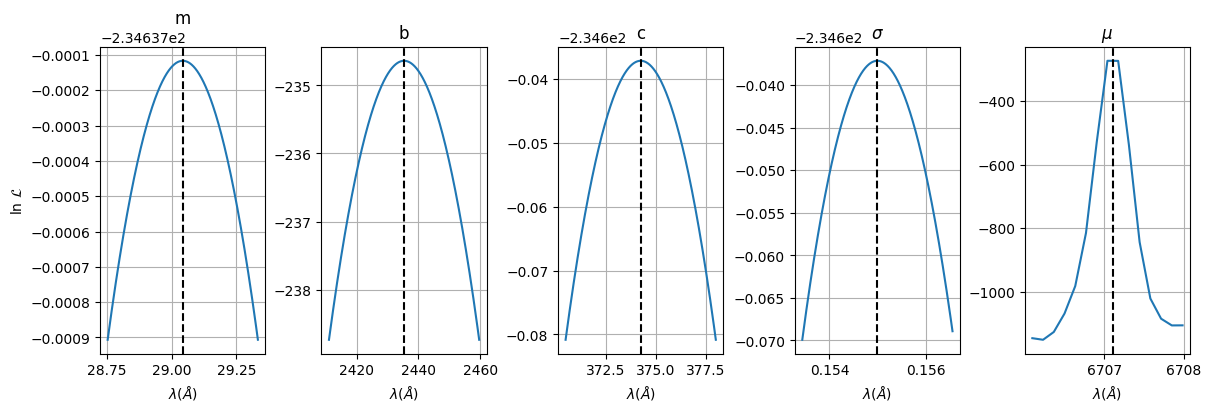

In [21]:
fig, axes = plt.subplots(1, 5, figsize=(12, 4), constrained_layout=True)
labels = ['m', 'b', 'c', r'$\sigma$', r'$\mu$']

for j, (label, ax) in enumerate(zip(labels, axes)):
    # get the best-fitting values
    trial_p = best_p.copy()

    # take a range around the j-th parameter's best-fiting value
    test_set = best_p[j] * np.linspace(0.99, 1.01, 1000)

    # get the log-likelihood for the different values (keeping fixed the rest of the parameters)
    ll = np.zeros_like(test_set)
    for i, test_val in enumerate(test_set):
        trial_p[j] = test_val
        ll[i] = ln_likelihood(trial_p, lithium_line)


    ax.plot(test_set, ll)
    ax.axvline(best_p[j], color='k', linestyle='dashed')    
    ax.set_title(labels[j])
    ax.set_xlabel(r'$\lambda (\AA)$')
    ax.grid()

axes[0].set_ylabel('ln $\mathcal{L}$')
plt.show()